# Analysing Smartphone Prices

In [77]:
import requests
from urllib import parse
import re

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## 1. Loading Devices Names

In [104]:
RELATIVE_PATH_TO_DATA_FOLDER = './data/'
filename = 'devices_using_ribonapp_data'
filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + filename + '.csv'
devices_df = pd.read_csv(filename_with_path, skiprows=0, names=['model_name', 'old_price_range'])
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1130 non-null   object
 1   old_price_range  1130 non-null   object
dtypes: object(2)
memory usage: 17.8+ KB


### 1.1 Cleaning Duplicates and Missing Values

In [105]:
devices_df.drop_duplicates(['model_name'], inplace=True)
devices_df.dropna(axis=0, inplace=True)
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 0 to 1129
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1130 non-null   object
 1   old_price_range  1130 non-null   object
dtypes: object(2)
memory usage: 26.5+ KB


## 2. Searching for Prices

In [22]:
url_base = "https://celulares.mercadolivre.com.br/"
item_list = devices_df['model_name'].to_list()

url_list = [url_base + parse.quote(item_name) for item_name in item_list]
item_list_tuple = []

for url, item_original_name in tdqm(zip(url_list, item_list)):
    r = requests.get(url)
    text_content = str(r.text)
    item_name = re.search(r'class="main-title">([\s\S]+?)<\/span>', text_content)
    item_price = re.search(r'price__fraction">(\S+)<\/span>', text_content)
    if item_name:
        item_name = item_name.groups()[0]
    if item_price:
        item_price = item_price.groups()[0]
    item_list_tuple.append((item_original_name, item_name, item_price))


extracted_data_df = pd.DataFrame(data=item_list_tuple, columns=['item_original_name','item_extracted_name', 'item_price'])
print(extracted_data_df.info())

https://celulares.mercadolivre.com.br/deviceModel


https://celulares.mercadolivre.com.br/2%20A2005


https://celulares.mercadolivre.com.br/3
(' Samsung Galaxy A30s Dual SIM 64 GB Prism crush white 4 GB RAM ',)
('1.111',)


https://celulares.mercadolivre.com.br/3T
(' Celular Oneplus 3t Dual A3010 4g 64gb 5.5 16mp/16mp Cinza ',)
('2.400',)


https://celulares.mercadolivre.com.br/4047D


https://celulares.mercadolivre.com.br/5
(' Samsung Galaxy J2 Core Dual SIM 16 GB Prata (Lavanda) 1 GB RAM ',)
('519',)


https://celulares.mercadolivre.com.br/5051J
(' Celular Alcatel Pop 4 5051j ',)
('239',)


https://celulares.mercadolivre.com.br/5056D


https://celulares.mercadolivre.com.br/5056E


https://celulares.mercadolivre.com.br/5T
(' Huawei Nova Series Nova 5t Dual SIM 128 GB Black 8 GB RAM ',)
('2.800',)


https://celulares.mercadolivre.com.br/6
(' Samsung Galaxy J4 Core Dual SIM 16 GB Preto 1 GB RAM ',)
('619',)


https://celulares.mercadolivre.com.br/6039J
(' Alcatel Idol 3 6039 Dual 4.7 4g



https://celulares.mercadolivre.com.br/BLADE%20A610


https://celulares.mercadolivre.com.br/BLADE%20L110
(' Celular Zte Blade L110 Defeito (ler Descricao) 2/19 ',)
('50',)


https://celulares.mercadolivre.com.br/BLADE%20V0800


https://celulares.mercadolivre.com.br/BLU%20Dash%20XL
(' Smartphone Blu Dash Xl {d710l} ',)
('449',)


https://celulares.mercadolivre.com.br/BLU%20Grand%20M
(' BLU Z5 Dual SIM 32 MB Cinza 32 MB RAM ',)
('92',)


https://celulares.mercadolivre.com.br/BLU%20S1
(' BLU Zoey Flex Dual SIM 32 MB Dourado 32 MB RAM ',)
('550',)


https://celulares.mercadolivre.com.br/BLU%20STUDIO%20J8%20LTE
(' Celular Blu Studio J8 Lte Preço Negociável ',)
('190',)


https://celulares.mercadolivre.com.br/BLU%20VIVO%20XL2
(' Motorola Moto Z Z2 Play Dual SIM 64 GB Ouro-fino 4 GB RAM ',)
('1.800',)


https://celulares.mercadolivre.com.br/BLU%20Vivo%205%20Mini
(' Celular Touch Blu 5 Mini ',)
('195',)


https://celulares.mercadolivre.com.br/BLade%20Zmax


https://celulares.mercadolivre.com.

(' Galaxy S3 Neo I9300i Para Retirar Peças Ref X14 ',)
('30',)


https://celulares.mercadolivre.com.br/Galaxy%20A10
(' Samsung Galaxy A10 Dual SIM 32 GB Preto 2 GB RAM ',)
('819',)


https://celulares.mercadolivre.com.br/Galaxy%20A10e
(' Samsung Galaxy 10.1 ',)
('800',)


https://celulares.mercadolivre.com.br/Galaxy%20A20
(' Samsung Galaxy A20 Dual SIM 32 GB Preto 3 GB RAM ',)
('1.099',)


https://celulares.mercadolivre.com.br/Galaxy%20A20e


https://celulares.mercadolivre.com.br/Galaxy%20A3
(' Samsung Galaxy A3 Dual SIM 16 GB Preto-meia-noite 1 GB RAM ',)
('699',)


https://celulares.mercadolivre.com.br/Galaxy%20A3%20Duos
(' Samsung Galaxy A3 Dual SIM 16 GB Preto-meia-noite 1 GB RAM ',)
('699',)


https://celulares.mercadolivre.com.br/Galaxy%20A3%282016%29
(' Celular Samsung Galaxy A3 2016 Usado Seminovo Muito Bom ',)
('419',)


https://celulares.mercadolivre.com.br/Galaxy%20A3%282017%29
(' Celular ',)
('330',)


https://celulares.mercadolivre.com.br/Galaxy%20A30
(' Samsung Galaxy A30

(' Samsung Galaxy J2 Core Dual SIM 16 GB Prata (Lavanda) 1 GB RAM ',)
('519',)


https://celulares.mercadolivre.com.br/Galaxy%20J2%20Core
(' Samsung Galaxy J2 Core Dual SIM 16 GB Prata (Lavanda) 1 GB RAM ',)
('519',)


https://celulares.mercadolivre.com.br/Galaxy%20J2%20Prime
(' Samsung Galaxy J2 Prime Dual SIM 16 GB Preto 1.5 GB RAM ',)
('748',)


https://celulares.mercadolivre.com.br/Galaxy%20J2%20Pro
(' Celular Samsung Galaxy J2 Pro Usado Seminovo Mt Bom ',)
('439',)


https://celulares.mercadolivre.com.br/Galaxy%20J3
(' Samsung Galaxy J3 (2016) Dual SIM 8 GB Dourado 1.5 GB RAM ',)
('579',)


https://celulares.mercadolivre.com.br/Galaxy%20J3%20Pop
(' Samsung Galaxy J3 (2016) Dual SIM 8 GB Dourado 1.5 GB RAM ',)
('579',)


https://celulares.mercadolivre.com.br/Galaxy%20J3%20Pro
(' Celular J3 ',)
('80',)


https://celulares.mercadolivre.com.br/Galaxy%20J3%282016%29
(' Samsung Galaxy J3 (2016) Dual SIM 8 GB Dourado 1.5 GB RAM ',)
('579',)


https://celulares.mercadolivre.com.br/Galaxy%

(' Celular Samsung S 5310 Para Retirar Peças Os 10110 ',)
('39',)


https://celulares.mercadolivre.com.br/Galaxy%20Pocket%20Neo%20S5310
(' Samsung Galaxy Pocket Neo S5310 3g Android 4.1 - Novo ',)
('329',)


https://celulares.mercadolivre.com.br/Galaxy%20S%205%20%28T-Mobile%29%20%5BSM-G900T%5D


https://celulares.mercadolivre.com.br/Galaxy%20S%20Advance%20%28GT-i9070/GT-i9070P%29
(' Samsung Galaxy A20s 32 GB Preto 3 GB RAM ',)
('1.233',)


https://celulares.mercadolivre.com.br/Galaxy%20S%20II%20%28GT-I9100%29
(' Smartphone Samsung Galaxy S2 Com 16gb De Memória Preto ',)
('451',)


https://celulares.mercadolivre.com.br/Galaxy%20S%20II%20GT-S7273T
(' Celular Samsung Unico Dono Galaxy S Ii 2 Tv Compl Impec Caix ',)
('320',)


https://celulares.mercadolivre.com.br/Galaxy%20S%20III
(' Samsung Galaxy S III Mini 8 GB Pebble blue 1 GB RAM ',)
('449',)


https://celulares.mercadolivre.com.br/Galaxy%20S%20III%20mini%20%28GT-I8200L%29
(' Samsung Galaxy S3 Mini Gt-i8200l (com Defeito) ',)
('90',)


(' Sansung Tab Pro T320 8.4 Res 2500x1600p 32gb Sd Classe 10 ',)
('800',)


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S%2010.5%28SM-T800%29


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S%208.4%20%28SM-T700%29


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S%208.4%20LTE%20SM-T705


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S2%208.0


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S2%209.7
(' Samsung Galaxy Tab S2 Sm-t815 4g 32gb- Class Top A ',)
('1.500',)


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S4


https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S5e


https://celulares.mercadolivre.com.br/Galaxy%20Tab4%207.0
(' Samsung Galaxy A70 Dual SIM 128 GB Preto 6 GB RAM ',)
('2.399',)


https://celulares.mercadolivre.com.br/Galaxy%20Tab4%20Active
(' Samsung Galaxy S10+ Dual SIM 128 GB Preto-prisma 8 GB RAM ',)
('3.599',)


https://celulares.mercadolivre.com.br/Galaxy%20TabA%20Plus%2010.1
(' Galaxy Tab 2 10.1 Samsung Em Boas Condi

(' Honor 9 Litee ',)
('650',)


https://celulares.mercadolivre.com.br/Honor%20Note10
(' Huawei Honor Note 10 6gb 128gb Tela 6,95 Bateria 5000mah ',)
('2.500',)


https://celulares.mercadolivre.com.br/Honor%20Play
(' Huawei Honor Play ( Disponível) ',)
('1.250',)


https://celulares.mercadolivre.com.br/Honor%20V10
(' Huawei Honor V10 - 6gb + 64gb - Pronta Entrega! Cor Azul ',)
('2.290',)


https://celulares.mercadolivre.com.br/Honor%20V9
(' Huawei Honor V9 Black 6/128gb ',)
('9.830',)


https://celulares.mercadolivre.com.br/Honor%20View%2010
(' Honor View 10 6gb / 128 Gb Dual 4g ',)
('1.200',)


https://celulares.mercadolivre.com.br/IDEOS%20S7


https://celulares.mercadolivre.com.br/IDOL%205
(' Alcatel One Touch Idol Mini 6012e 8gb Dual Original ',)
('284',)


https://celulares.mercadolivre.com.br/Iconia%20One%207


https://celulares.mercadolivre.com.br/Iconia%20One%207%20B1-730HD


https://celulares.mercadolivre.com.br/Ideatab%20A1000
(' Smartphone Lenovo A1000 Dual Chip Preto ',)
('64

(' Celular Lenovo K6 Note 32gb Biometria Com Poucas Marcas Uso ',)
('320',)


https://celulares.mercadolivre.com.br/Life
(' Xiaomi Mi 8 Lite Dual SIM 64 GB Midnight black 4 GB RAM ',)
('1.580',)


https://celulares.mercadolivre.com.br/Life%20One%20X3
(' Smartphone Blu Life One X3 4g Dual Sim 5.5 Fhd 32gb/3gb ',)
('1.099',)


https://celulares.mercadolivre.com.br/Liquid%20Zest%20Plus


https://celulares.mercadolivre.com.br/M1
(' Asus ZenFone Max M1 ZC520KL Dual SIM 32 GB Preto 2 GB RAM ',)
('819',)


https://celulares.mercadolivre.com.br/M10
(' Samsung Galaxy M10 Dual SIM 32 GB Azul-oceano 3 GB RAM ',)
('868',)


https://celulares.mercadolivre.com.br/M10A-Lite


https://celulares.mercadolivre.com.br/M13
(' Celular Leagoo M13 4 32 Android 9.0 Global Pronta Entrega ',)
('730',)


https://celulares.mercadolivre.com.br/M4%20SS4458


https://celulares.mercadolivre.com.br/M5
(' Sony Xperia M5 16 GB Preto 3 GB RAM ',)
('1.299',)


https://celulares.mercadolivre.com.br/M6
(' Celular Meizu M6 An

(' Xiaomi Mi A3 Dual SIM 64 GB Acinzentado 4 GB RAM ',)
('1.470',)


https://celulares.mercadolivre.com.br/Mi%20Note2
(' Xiaomi Mi Note 10 Dual SIM 128 GB Branco glaciar 6 GB RAM ',)
('3.394',)


https://celulares.mercadolivre.com.br/Mini%20S50


https://celulares.mercadolivre.com.br/Mobi%20Tab
(' Lote De 4 Celulares No Estado Para Peças ',)
('59',)


https://celulares.mercadolivre.com.br/Motion
(' Smartphone Cce Motion Plus Sm70 - Defeito ',)
('19',)


https://celulares.mercadolivre.com.br/Motion%20Plus%20Sk351
(' Celular Cce Sk351 Para Retirada De Peças Ref: L97 ',)
('30',)


https://celulares.mercadolivre.com.br/Moto%20C
(' Motorola Moto G G (3rd Gen.) Dual SIM 16 GB Preto 2 GB RAM ',)
('649',)


https://celulares.mercadolivre.com.br/Moto%20C%20Plus
(' Motorola Moto C C Plus Dual SIM 8 GB Preto-brilhante 1 GB RAM ',)
('549',)


https://celulares.mercadolivre.com.br/Moto%20E%20%284%29%20Plus
(' Celular Motorola Moto E4 Plus 16gb Usado Seminovo Muito Bom ',)
('489',)


https://celular

(' Nokia Lumia 925 - Windows 8, 4g, 8.7 Mp, 16 Gb - Novo ',)
('699',)


https://celulares.mercadolivre.com.br/Nokia%207%20plus
(' Nokia 7 Plus Desbloqueado 6gb/64gb Android 10 !! ',)
('1.499',)


https://celulares.mercadolivre.com.br/Nokia%207.1
(' Nokia Lumia 930 32 GB Preto 2 GB RAM ',)
('748',)


https://celulares.mercadolivre.com.br/Nokia%209
(' 1 Celular Nokia 200 Rm-761 E 2 Celula Rm-799 Leia Descrição ',)
('39',)


https://celulares.mercadolivre.com.br/Note%205A%20Prime
(' Xiaomi Redmi Note 5a Prime 3gb/32gb Display Trincado ',)
('450',)


https://celulares.mercadolivre.com.br/OPTIMUS%20L5II%20%28E450F%29%20TITANIUM
(' Smartphone LG E450f - Defeito ',)
('25',)


https://celulares.mercadolivre.com.br/One
(' Motorola One Hyper Dual SIM 128 GB Deepsea blue 4 GB RAM ',)
('1.839',)


https://celulares.mercadolivre.com.br/One%20%28A0001%29


https://celulares.mercadolivre.com.br/One%20%28M8%29
(' Original Htc One M8 16gb/32gb Rom 5.0 Frete Gratis ',)
('1.699',)


https://celulares.mer

(' Smartphone Quantum Muv Q5 16gb Dual Rosa Original ',)
('429',)


https://celulares.mercadolivre.com.br/Q6
(' LG Q Series Q6 Dual SIM 32 GB Astro black 3 GB RAM ',)
('754',)


https://celulares.mercadolivre.com.br/Quantum%20Go
(' Celular Quantum Go2 4g 32gb/3gb Octa Core 13mp/13mp ',)
('479',)


https://celulares.mercadolivre.com.br/Quantum%20Lio%20%2B
(' Smartphone E Maquininha Cielo Quantum Lio+ Qc84 ',)
('699',)


https://celulares.mercadolivre.com.br/Quantum%20MUV%20PRO
(' Smartphone Quantum Muv Up Q13 Core 32gb 4g Wi-fi Câmera 13mp ',)
('599',)


https://celulares.mercadolivre.com.br/Quantum%20Muv
(' Celular Smartphone Quantum Muv Up 32gb Usado Excelente ',)
('709',)


https://celulares.mercadolivre.com.br/R1%20HD
(' Celular Blu R1 Hd R0011uu - 5.0 - Dual-sim - 8gb- 4g Lte ',)
('892',)


https://celulares.mercadolivre.com.br/R2%20LTE
(' Blu R2 R0171 Dual Sim 4g Lte Tela 5.2 Hd 32gb/3gb 13/13mp ',)
('580',)


https://celulares.mercadolivre.com.br/R2%20Plus


https://celulares.mer

(' Carregador Turbo . ',)
('70',)


https://celulares.mercadolivre.com.br/Smart%20ultra%207


https://celulares.mercadolivre.com.br/Smart_N9_Lite
(' Huawei P Series P Smart 2019 Dual SIM 64 GB Azul-aurora 3 GB RAM ',)
('1.669',)


https://celulares.mercadolivre.com.br/Smarti%20ANDROID%20S420
(' Samsung Galaxy S9 Dual SIM 128 GB Cinza-titânio 4 GB RAM ',)
('2.288',)


https://celulares.mercadolivre.com.br/Spirit%204G%20MS870
(' Lg Spirit 3g H420 Usado! ',)
('360',)


https://celulares.mercadolivre.com.br/Spree
(' Lg K4 K120 (com Defeito) ',)
('70',)


https://celulares.mercadolivre.com.br/Starnaute%204


https://celulares.mercadolivre.com.br/Studio%20C%20HD
(' Celular Blu Studio C Hd S-090q - 5.0 - Dual-sim - 8gb - 3g ',)
('339',)


https://celulares.mercadolivre.com.br/Studio%20J2
(' Celular Blu Grand Studio J2 Lacrado Anatel Tela5 Android Nfe ',)
('599',)


https://celulares.mercadolivre.com.br/Studio%20View%20XL
(' Smartphone Blu Studio View Xl Dual Sim 3g 5.7 Garantia 1 Ano ',)
('59

(' Sony Xperia XZ Premium Dual SIM 64 GB Preto-mar-profundo 4 GB RAM ',)
('3.760',)


https://celulares.mercadolivre.com.br/X%20cam
(' Samsung Galaxy A30s Dual SIM 64 GB Prism crush white 4 GB RAM ',)
('1.111',)


https://celulares.mercadolivre.com.br/X%20max
(' Asus ZenFone Max Shot ZB634KL Dual SIM 64 GB Preto 4 GB RAM ',)
('945',)


https://celulares.mercadolivre.com.br/X%20power
(' Motorola Moto G G7 Power Dual SIM 64 GB Ceramic black 4 GB RAM ',)
('1.495',)


https://celulares.mercadolivre.com.br/X%20screen
(' Xiaomi Redmi 7A (13 Mpx) Dual SIM 16 GB Morning blue 2 GB RAM ',)
('678',)


https://celulares.mercadolivre.com.br/X008D


https://celulares.mercadolivre.com.br/X1%20Lite
(' Neffos X1 Lite ',)
('649',)


https://celulares.mercadolivre.com.br/X19
(' Cubot X19 ',)
('800',)


https://celulares.mercadolivre.com.br/X30
(' Celular ',)
('699',)


https://celulares.mercadolivre.com.br/X5%20max%20pro
(' Smartphone Doogee X5 Max Pro ',)
('400',)


https://celulares.mercadolivre.com.br

(' Huawei Y340-u081 Preto ',)
('450',)


https://celulares.mercadolivre.com.br/Y5
(' Celular Huawei Honor Y5ll Cun-u29 Dual 8gb Original Vitrine ',)
('558',)


https://celulares.mercadolivre.com.br/Y5II


https://celulares.mercadolivre.com.br/Y6
(' Celular Huawei Y6 2018 16gb 2gb Azul + Nf ',)
('949',)


https://celulares.mercadolivre.com.br/Y6%202017
(' Samsung Galaxy A5 (2017) 32 GB Preto 3 GB RAM ',)
('1.250',)


https://celulares.mercadolivre.com.br/Y6%202019


https://celulares.mercadolivre.com.br/Y6%20Max
(' Celular Huawei Y6 2018 16gb 2gb Azul + Nf ',)
('1.011',)


https://celulares.mercadolivre.com.br/Y7
(' Smartphone Huawei Y7 Pro - Global 4g + 64gb Azul ',)
('1.590',)


https://celulares.mercadolivre.com.br/Y7Plus


https://celulares.mercadolivre.com.br/Y8
(' Smartphone Doogee Y8 32gb 3gb Ram Verde ',)
('799',)


https://celulares.mercadolivre.com.br/Y9%20Prime%202019
(' Huawei Y9 Prime Dual 128gb - Câmera Pop Up - Completo + Case ',)
('1.500',)


https://celulares.mercadoliv



https://celulares.mercadolivre.com.br/iPad%203rd%20Gen%20%28Wi-Fi%20Only%29


https://celulares.mercadolivre.com.br/iPad%203rd%20Gen%20%28Wi-Fi/4G%20LTE%20Verizon/GPS%29


https://celulares.mercadolivre.com.br/iPad%204th%20Gen%20%28Wi-Fi%20Only%29


https://celulares.mercadolivre.com.br/iPad%204th%20Gen%20%28Wi-Fi/4G%20LTE%20AT%26T/GPS%29


https://celulares.mercadolivre.com.br/iPad%206th%20Generation


https://celulares.mercadolivre.com.br/iPad%209.7-Inch%205th%20Gen%20%28Cellular%29


https://celulares.mercadolivre.com.br/iPad%209.7-Inch%205th%20Gen%20%28WIFI%29


https://celulares.mercadolivre.com.br/iPad%20Air%20%28Wi-Fi%20Only%29
(' iPad Mini 3 Wifi 64gb - A1599 ',)
('1.500',)


https://celulares.mercadolivre.com.br/iPad%20Air%20%28iPad4%2C2%29
(' Apple iPhone 5c 8 GB Branco 1 GB RAM ',)
('849',)


https://celulares.mercadolivre.com.br/iPad%20Air%202%20-%20Cellular


https://celulares.mercadolivre.com.br/iPad%20Air%202%20-%20Wi-fi


https://celulares.mercadolivre.com.br/iPad%20M

(' Samsung Galaxy J2 Core Dual SIM 16 GB Prata (Lavanda) 1 GB RAM ',)
('519',)


https://celulares.mercadolivre.com.br/t1_8p0lte
(' Celular Motorola V60i Não É Nem Usa Chip. Enviamos T.brasil ',)
('75',)


https://celulares.mercadolivre.com.br/vivo%201724
(' Multilaser Flip Vita Dual SIM 32 MB Azul/Preto 32 MB RAM ',)
('167',)


https://celulares.mercadolivre.com.br/vivo%20X9
(' Multilaser Flip Vita Dual SIM 32 MB Azul/Preto 32 MB RAM ',)
('167',)


https://celulares.mercadolivre.com.br/vivo%20Y53
(' Multilaser Flip Vita Dual SIM 32 MB Azul/Preto 32 MB RAM ',)
('167',)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   item_original_name   1130 non-null   object
 1   item_extracted_name  903 non-null    object
 2   item_price           903 non-null    object
dtypes: object(3)
memory usage: 26.6+ KB
None


### 2.1 Treating Data

In [42]:

extracted_data_df.dropna(axis=0, inplace=True)
item_raw_prices_list = extracted_data_df['item_price'].to_list()
item_treated_prices_list = []
for item_raw_price in item_raw_prices_list:
    item_price = None
    if '.' in item_raw_price:
        thousands_digits, hundreds_digits = item_raw_price.split('.')
        item_price = int(thousands_digits)*1000 + int(hundreds_digits)
    else:
        item_price = int(item_raw_price)
    item_treated_prices_list.append(item_price)
extracted_data_df['item_price'] = item_treated_prices_list
extracted_data_df

,item_original_name,item_extracted_name,item_price
2,3,Samsung Galaxy A30s Dual SIM 64 GB Prism crus...,1111
3,3T,Celular Oneplus 3t Dual A3010 4g 64gb 5.5 16m...,2400
5,5,Samsung Galaxy J2 Core Dual SIM 16 GB Prata (...,519
6,5051J,Celular Alcatel Pop 4 5051j,239
9,5T,Huawei Nova Series Nova 5t Dual SIM 128 GB Bl...,2800
...,...,...,...
1125,nova 4,Samsung Galaxy J2 Core Dual SIM 16 GB Prata (...,519
1126,t1_8p0lte,Celular Motorola V60i Não É Nem Usa Chip. Env...,75
1127,vivo 1724,Multilaser Flip Vita Dual SIM 32 MB Azul/Pret...,167
1128,vivo X9,Multilaser Flip Vita Dual SIM 32 MB Azul/Pret...,167


### 2.1 Storing Found Prices

In [43]:
extracted_filename = 'extracted_device_data'
extracted_filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + extracted_filename + '.csv'

In [45]:
extracted_data_df.to_csv(extracted_filename_with_path, index=False)

## 3. Analysing Prices

In [46]:
device_extracted_data_df = pd.read_csv(extracted_filename_with_path, header=0)
device_extracted_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   item_original_name   903 non-null    object
 1   item_extracted_name  903 non-null    object
 2   item_price           903 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.3+ KB


### 3.1 Prices Distribution

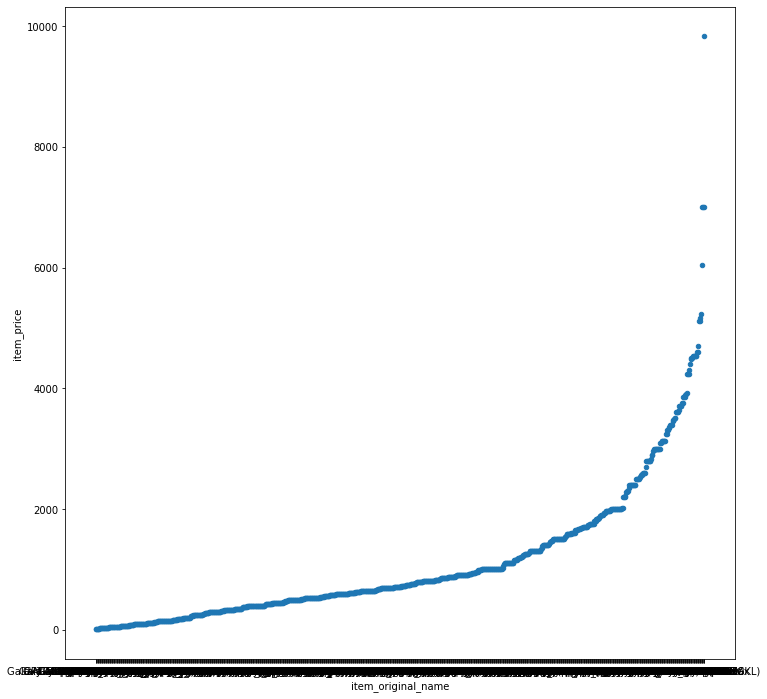

In [81]:
device_extracted_data_df.sort_values(by='item_price', inplace=True)
device_extracted_data_df.plot.scatter(x=0, y='item_price', figsize=(12, 12))

### 3.2 Prices Binning

In [84]:
device_extracted_data_df.describe()
device_extracted_data_df.plot.hist(by=['item_price'], bins=4, figsize=(8, 8))


,item_price
count,903.000000
mean,1095.625692
std,1128.563893
min,6.000000
25%,397.500000
50%,713.000000
75%,1470.000000
max,9830.000000


#### Using Quantiles

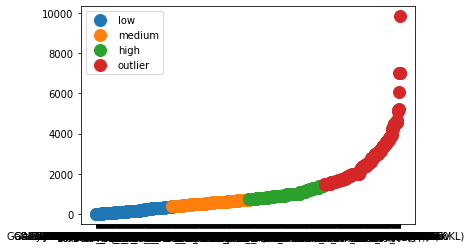

In [102]:
price_range_labels = ['low', 'medium', 'high', 'outlier']
device_extracted_data_df['price_range_q'] = pd.qcut(device_extracted_data_df['item_price'], q=4, labels=price_range_labels)
groups = device_extracted_data_df.groupby('price_range_q')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

#### Using Binning

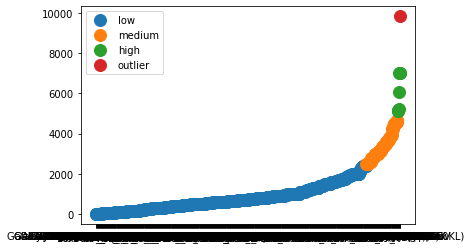

In [103]:
price_range_labels = ['low', 'medium', 'high', 'outlier']
device_extracted_data_df['price_range_bin'] = pd.cut(device_extracted_data_df['item_price'], bins=4, labels=price_range_labels)
groups = device_extracted_data_df.groupby('price_range_bin')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

#### Comparing with old price ranges

In [110]:
device_extracted_data_df = device_extracted_data_df.merge(right=devices_df, left_on='item_original_name', right_on='model_name', how='inner').drop(columns='model_name')
device_extracted_data_df

,item_original_name,item_extracted_name,item_price,price_range,price_range_q,price_range_bin,old_price_range
0,Breeze 7Y2241,Conector Micro Usb Tablet Aoc Breeze Aoc 7 7y...,6,low,low,low,Low
1,Galaxy Trend Lite GT-S7392L DUOS,Celular Samsung Galaxy Trend Lite Gt-s7392l P...,15,low,low,low,Mid_Range
2,E470f,Smartphone Lg E470f Branco Apenas Partes Pçs....,18,low,low,low,Low
3,Motion,Smartphone Cce Motion Plus Sm70 - Defeito,19,low,low,low,Low
4,Galaxy Pocket 2,Smartphone Samsung Galaxy Pocket 2 Duos Sm-g1...,19,low,low,low,Mid_Range
...,...,...,...,...,...,...,...
898,One Pro,OnePlus 7T Pro McLaren Edition Dual SIM 256 G...,6049,high,outlier,high,Low
899,Max 4 Pro,Apple iPhone 11 Pro Max Dual SIM 64 GB Cinza-...,7000,high,outlier,high,Low
900,iPhone 11 Pro,Apple iPhone 11 Pro Max Dual SIM 64 GB Cinza-...,7000,high,outlier,high,High
901,iPhone 11 Pro Max,Apple iPhone 11 Pro Max Dual SIM 64 GB Cinza-...,7000,high,outlier,high,High


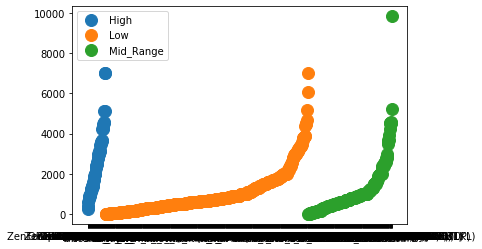

In [111]:
groups = device_extracted_data_df.groupby('old_price_range')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()